Reference from - https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

In [39]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [40]:
df = pd.read_csv("../../dateset/creditcard.csv")

In [41]:
df.shape

(284807, 31)

In [42]:
df.isnull().values.any()

False

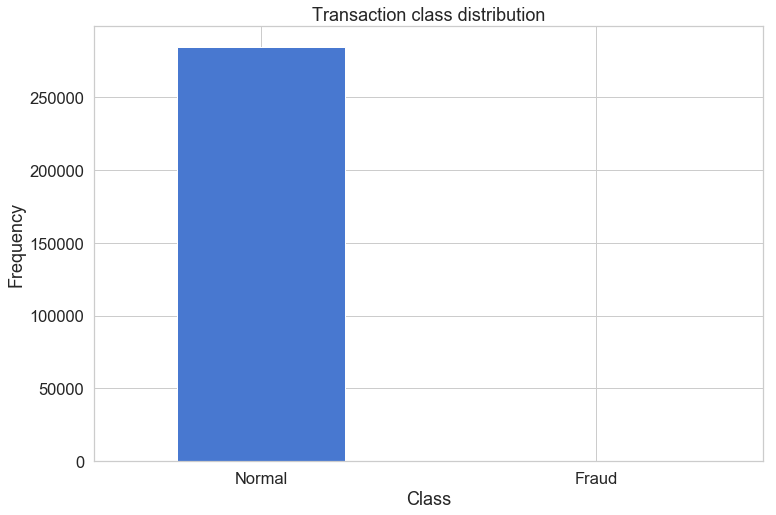

In [43]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [44]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds.shape

(492, 31)

In [45]:
normal.shape

(284315, 31)

In [46]:
print (frauds.Amount.describe())
print ()
print (normal.Amount.describe())


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


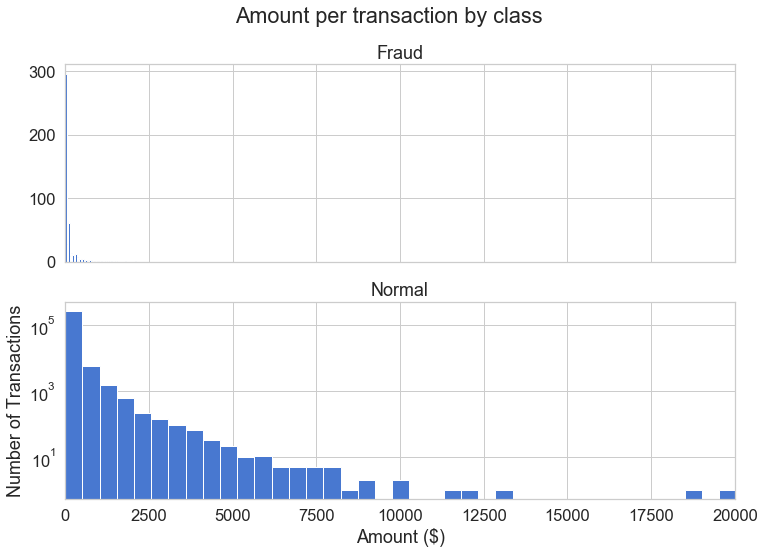

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

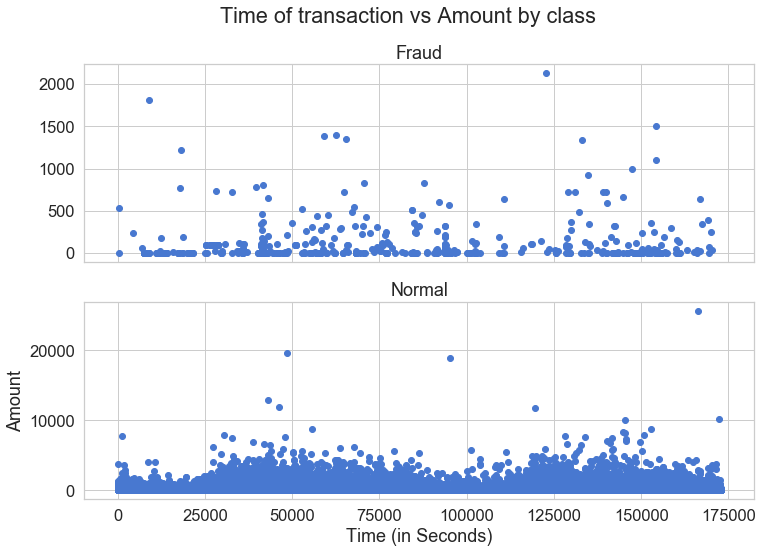

In [48]:
f, (ax1, ax2)= plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')


ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [49]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [50]:
data['Amount'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: Amount, dtype: float64

In [51]:
df['Amount'].head()

0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64

# Preparing the data

In [52]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
print (X_train.head())
X_train = X_train[X_train.Class == 0]
print (X_train.head())
X_train = X_train.drop(['Class'], axis=1)
print (X_train.head())
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
print (X_train[5])

              V1        V2        V3        V4        V5        V6        V7  \
223361  1.955041 -0.380783 -0.315013  0.330155 -0.509374 -0.086197 -0.627978   
165061 -0.400975 -0.626943  1.555339 -2.017772 -0.107769  0.168310  0.017959   
238186  0.072509  0.820566 -0.561351 -0.709897  1.080399 -0.359429  0.787858   
150562 -0.535045  1.014587  1.750679  2.769390  0.500089  1.002270  0.847902   
138452 -4.026938  1.897371 -0.429786 -0.029571 -0.855751 -0.480406 -0.435632   

              V8        V9       V10  ...         V21       V22       V23  \
223361  0.035994  1.054560 -0.030441  ...    0.238197  0.968305  0.053208   
165061 -0.401619  0.040378  0.611115  ...   -0.153485  0.421703  0.113442   
238186  0.117276 -0.131275 -0.638222  ...   -0.314638 -0.872959  0.083391   
150562 -0.081323  0.371579  0.560595  ...    0.063525  0.443431 -0.072754   
138452  1.313760  0.536044  1.221746  ...   -0.480691 -0.230369  0.250717   

             V24       V25       V26       V27       V28

In [53]:
X_train.shape

(227451, 29)

In [54]:
X_test.shape

(56962, 29)

# Building the model

In [55]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [57]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)



In [58]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 29s 127us/step - loss: 0.8202 - acc: 0.5858 - val_loss: 0.8044 - val_acc: 0.6373
Epoch 2/100
227451/227451 [==============================] - 29s 130us/step - loss: 0.7561 - acc: 0.6584 - val_loss: 0.7777 - val_acc: 0.6685
Epoch 3/100
227451/227451 [==============================] - 28s 122us/step - loss: 0.7414 - acc: 0.6657 - val_loss: 0.7701 - val_acc: 0.6675
Epoch 4/100
227451/227451 [==============================] - 30s 132us/step - loss: 0.7359 - acc: 0.6696 - val_loss: 0.7667 - val_acc: 0.6732
Epoch 5/100
227451/227451 [==============================] - 30s 130us/step - loss: 0.7317 - acc: 0.6752 - val_loss: 0.7657 - val_acc: 0.6741
Epoch 6/100
227451/227451 [==============================] - 31s 137us/step - loss: 0.7300 - acc: 0.6781 - val_loss: 0.7615 - val_acc: 0.6787
Epoch 7/100
227451/227451 [==============================] - 27s 118us/step - loss: 0.7286 - acc:

Epoch 58/100
227451/227451 [==============================] - 85s 375us/step - loss: 0.7200 - acc: 0.6848 - val_loss: 0.7545 - val_acc: 0.6891
Epoch 59/100
227451/227451 [==============================] - 79s 347us/step - loss: 0.7199 - acc: 0.6833 - val_loss: 0.7570 - val_acc: 0.6854
Epoch 60/100
227451/227451 [==============================] - 82s 360us/step - loss: 0.7197 - acc: 0.6843 - val_loss: 0.7620 - val_acc: 0.6745
Epoch 61/100
227451/227451 [==============================] - 82s 359us/step - loss: 0.7198 - acc: 0.6840 - val_loss: 0.7574 - val_acc: 0.6826
Epoch 62/100
227451/227451 [==============================] - 79s 350us/step - loss: 0.7200 - acc: 0.6839 - val_loss: 0.7545 - val_acc: 0.6809
Epoch 63/100
227451/227451 [==============================] - 80s 353us/step - loss: 0.7195 - acc: 0.6849 - val_loss: 0.7553 - val_acc: 0.6823
Epoch 64/100
227451/227451 [==============================] - 79s 349us/step - loss: 0.7195 - acc: 0.6847 - val_loss: 0.7545 - val_acc: 0.6848

In [59]:
autoencoder = load_model('model.h5')

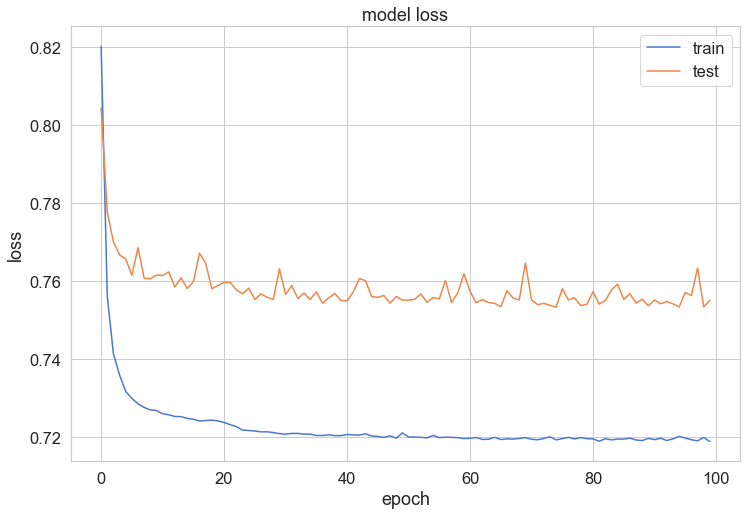

In [60]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [61]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.746237,0.001720
std,3.453560,0.041443
min,0.043251,0.000000
25%,0.237829,0.000000
50%,0.404337,0.000000
75%,0.644683,0.000000
max,262.962781,1.000000


# Reconstruction error without fraud

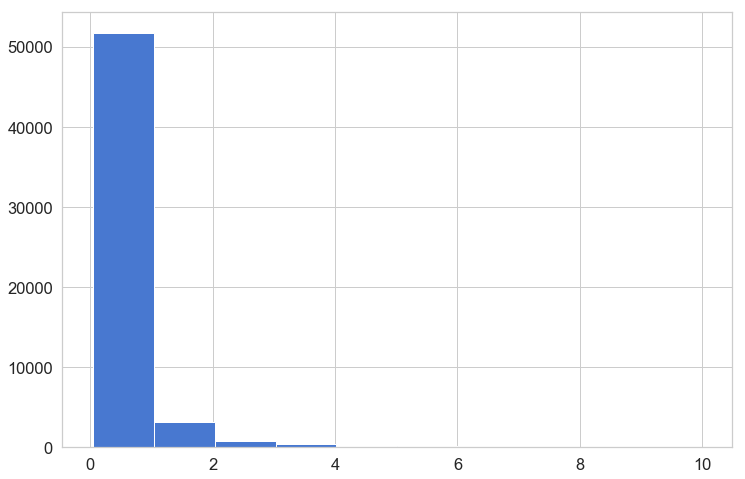

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

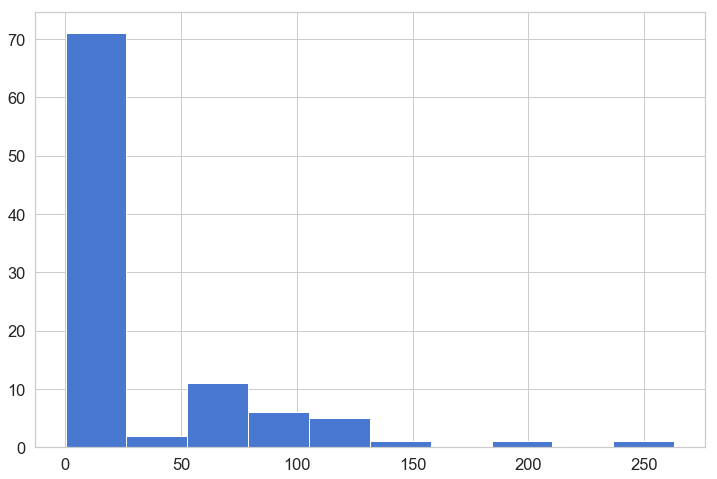

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [64]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

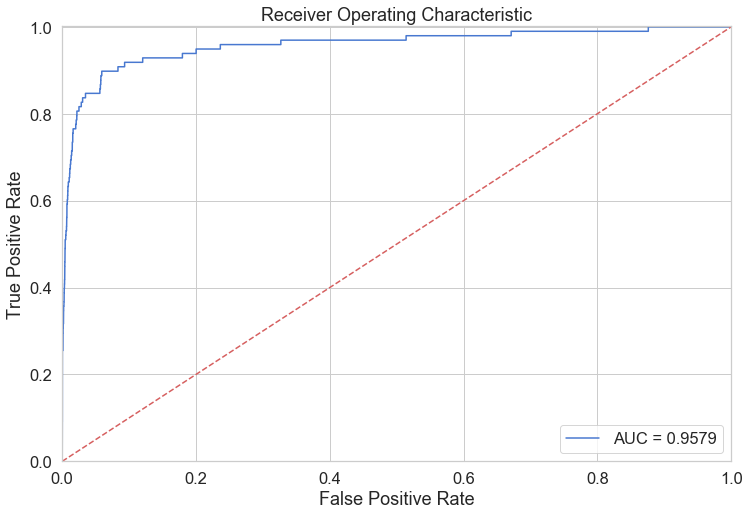

In [65]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

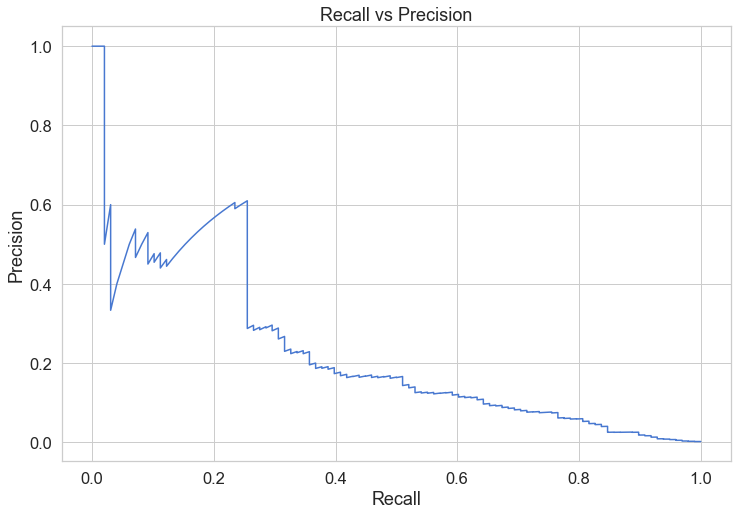

In [66]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

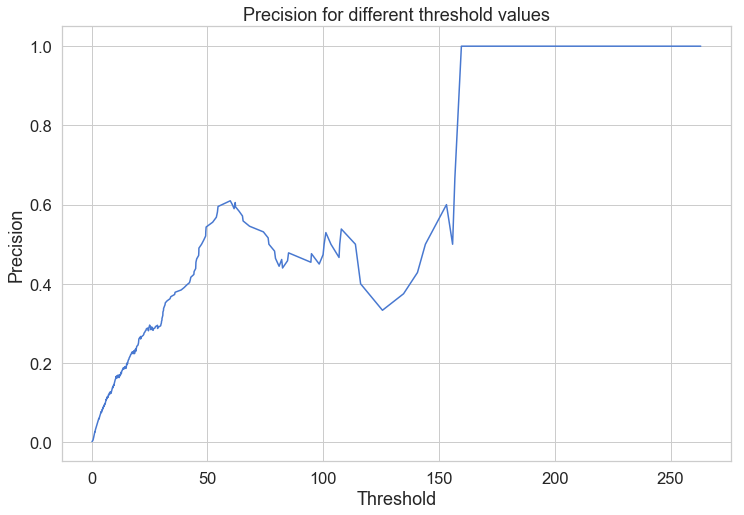

In [67]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

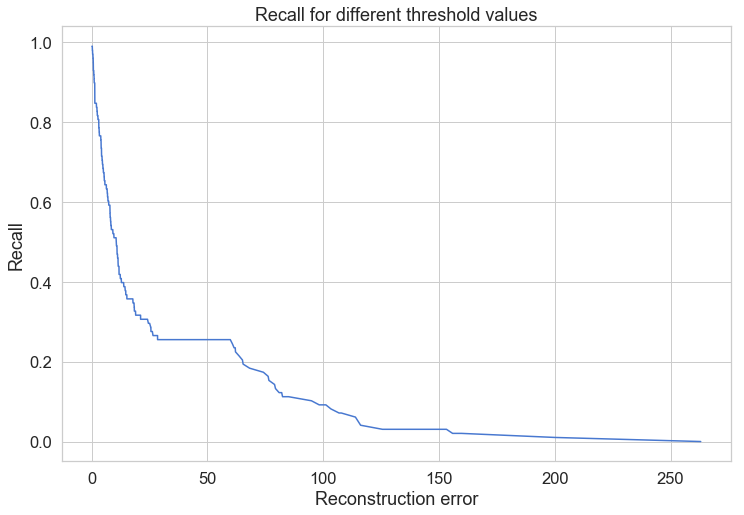

In [68]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [69]:
threshold = 2.5

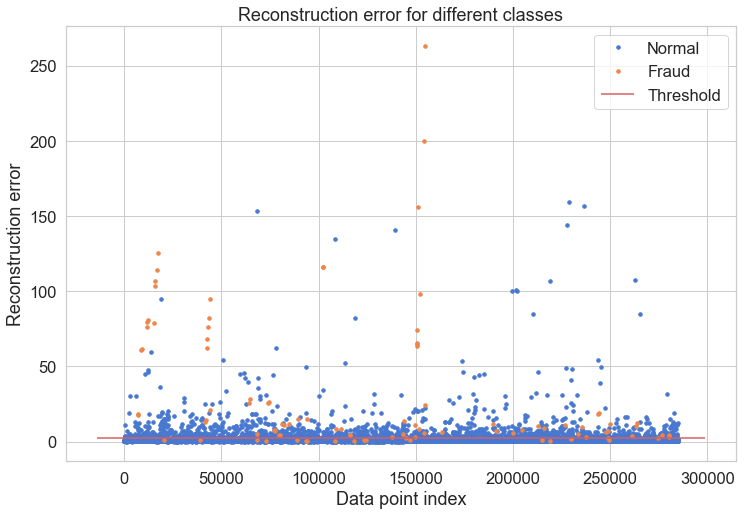

In [70]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

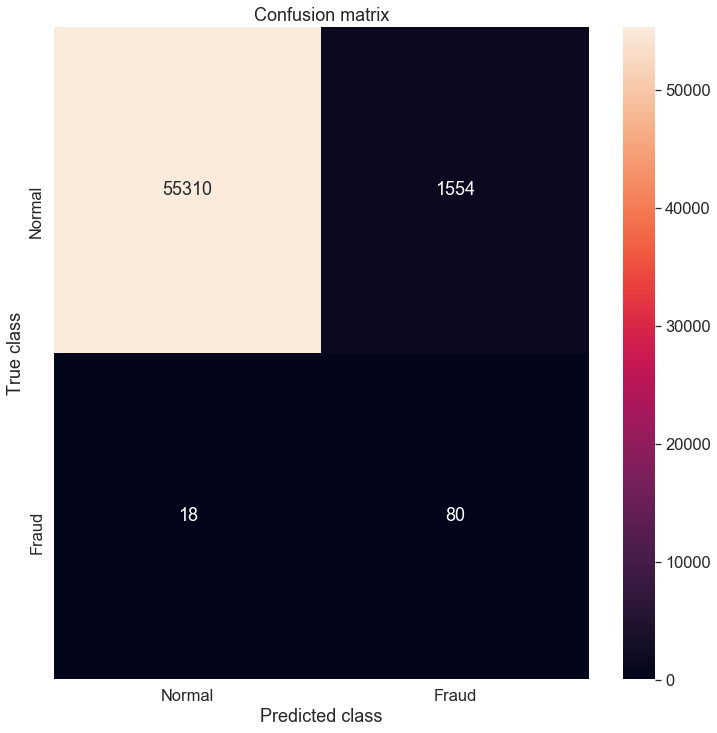

In [71]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [73]:
print ("***********Done*************")

***********Done*************
